In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from sklearn.linear_model import LinearRegression

figsize = (20,11)
legend_fontsize = 15
title_fontsize = 15
label_fontsize = 15
linewidth=3
sns.set_style("whitegrid")

from matplotlib import rc
rc('font',**{'family':'sans-serif', 'size': 12})

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1

  Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания)



https://ourworldindata.org/coronavirus-source-data

In [51]:
covid_df = pd.read_csv('/content/drive/MyDrive/MADE/2_полугодие_MADE/Advanced_ML/дз/owid-covid-data.csv')
covid_df = covid_df.loc[(covid_df["location"] == "Russia") & (covid_df["date"] >= "2020-03-03")]
covid_df["index"] = range(1, len(covid_df) + 1)
covid_df["new_cases"] = covid_df.new_cases.apply(lambda x: 1 if x <= 0 else x)

In [52]:
train_target_cols = ["index", "date", "total_cases", "new_cases"]

In [53]:
train_df = covid_df.iloc[:50, :].loc[:, train_target_cols].copy(deep=True)
test_df = covid_df.iloc[50:, :].loc[:, train_target_cols].copy(deep=True)

# 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

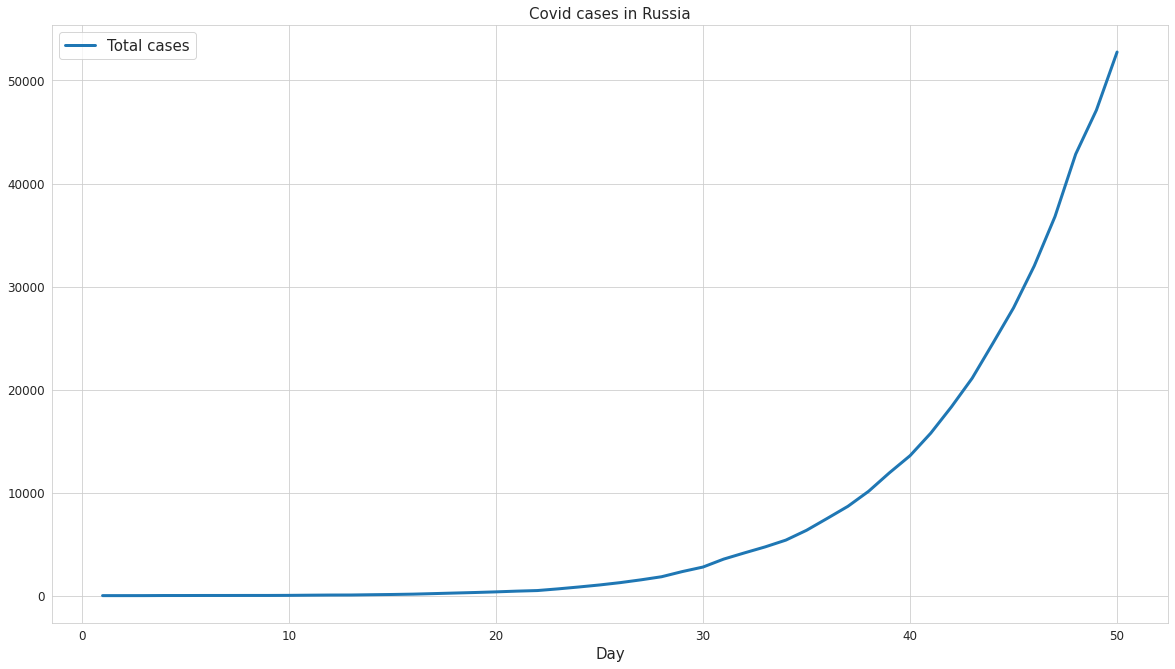

In [54]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlabel('Day', fontsize=label_fontsize)
ax.plot(train_df["index"], train_df["total_cases"], label='Total cases', linewidth=linewidth)

plt.title('Covid cases in Russia', fontsize=title_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.show()

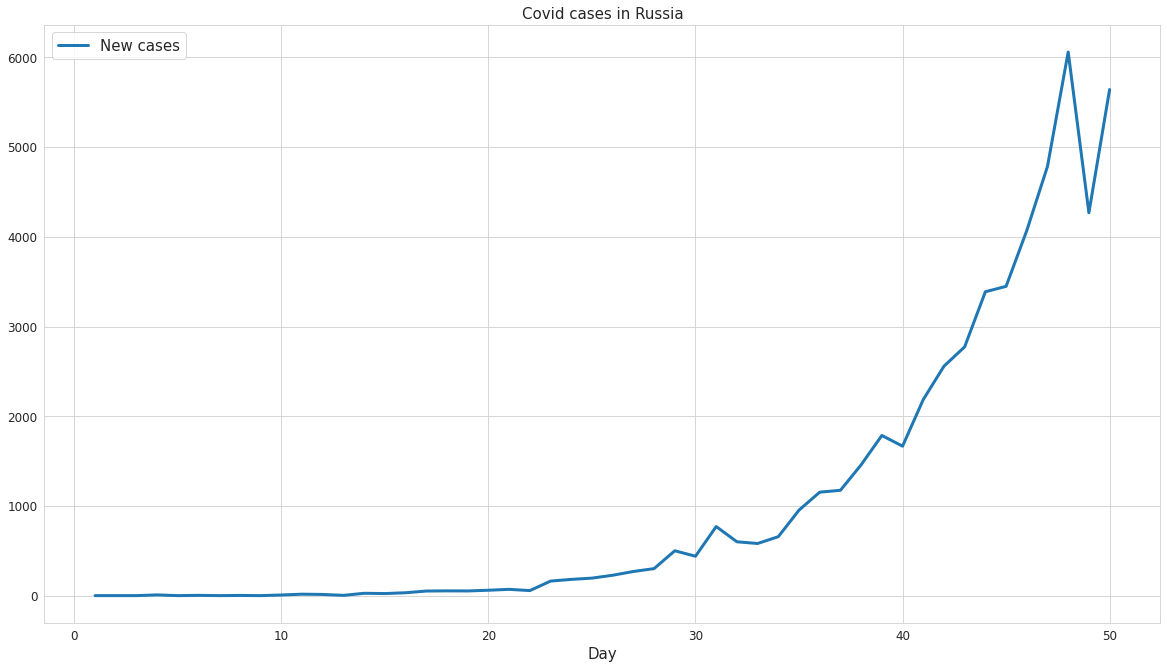

In [55]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlabel('Day', fontsize=label_fontsize)
ax.plot(train_df["index"], train_df["new_cases"], label='New cases', linewidth=linewidth)

plt.title('Covid cases in Russia', fontsize=title_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.show()

## a 
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня


In [56]:
lr_total = LinearRegression().fit(train_df["index"].values.reshape(-1, 1), np.log(train_df.total_cases))
lr_new = LinearRegression().fit(train_df["index"].values.reshape(-1, 1), np.log(train_df.new_cases))

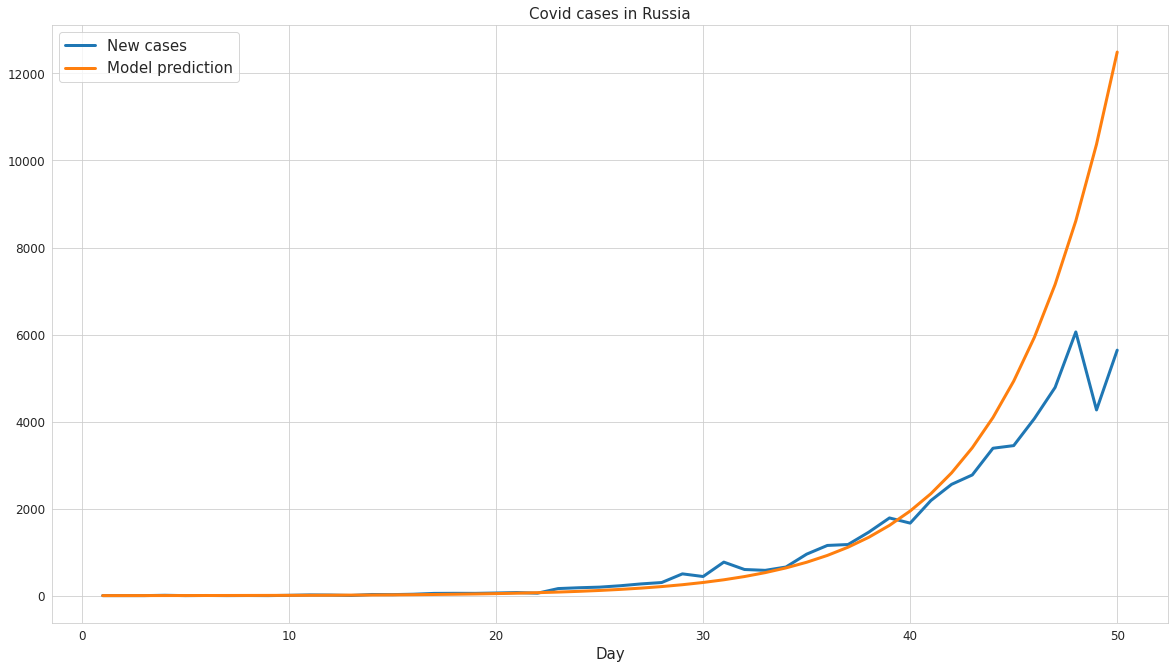

In [57]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlabel('Day', fontsize=label_fontsize)
ax.plot(train_df['index'], train_df["new_cases"], label='New cases', linewidth=linewidth)
ax.plot(train_df['index'], np.exp(lr_new.predict(train_df['index'].values.reshape(-1, 1))), label='Model prediction', linewidth=linewidth)

plt.title('Covid cases in Russia', fontsize=title_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.show()

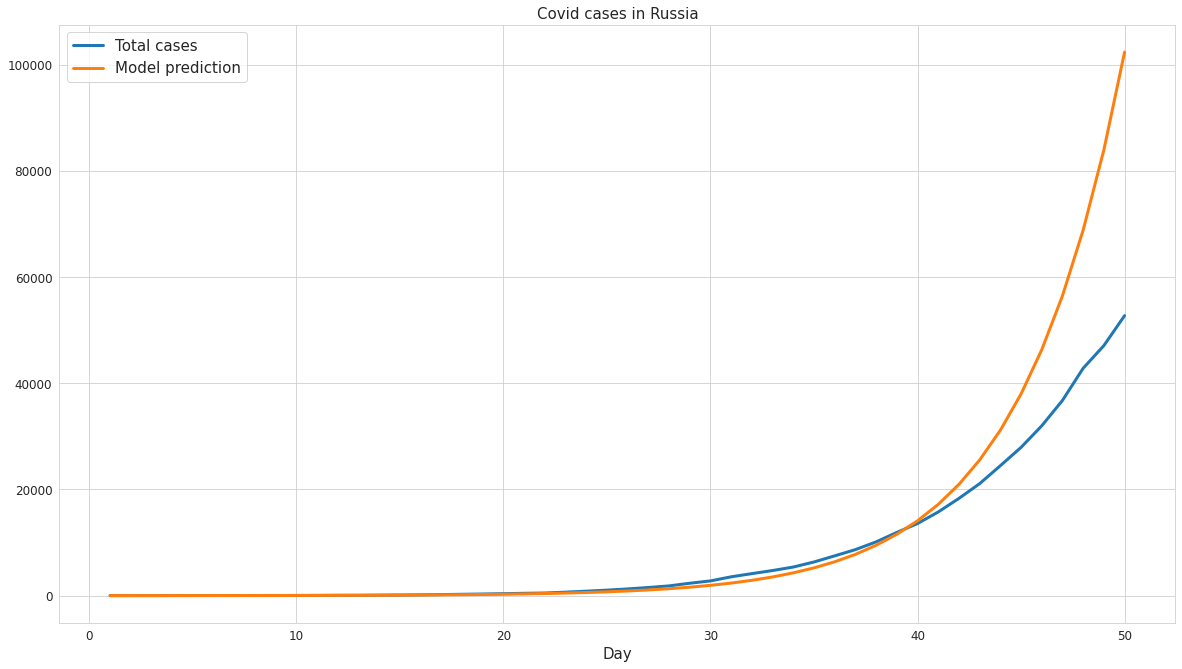

In [58]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlabel('Day', fontsize=label_fontsize)
ax.plot(train_df['index'], train_df["total_cases"], label='Total cases', linewidth=linewidth)
ax.plot(train_df['index'], np.exp(lr_total.predict(train_df['index'].values.reshape(-1, 1))), label='Model prediction', linewidth=linewidth)

plt.title('Covid cases in Russia', fontsize=title_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.show()

## b
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [59]:
std_new = np.std(np.log(train_df["new_cases"]) - lr_new.predict(train_df["index"].values.reshape(-1, 1)))
std_total = np.std(np.log(train_df["total_cases"]) - lr_total.predict(train_df["index"].values.reshape(-1, 1)))

mu_0_new = np.array([lr_new.intercept_, lr_new.coef_[0]])
mu_0_total = np.array([lr_total.intercept_, lr_total.coef_[0]])

$$ \Sigma_{N}^{-1} = \Sigma_{0}^{-1} + \frac{1}{\sigma^{2}} X^{T}X $$
$$ \mu_{N} = \Sigma_{N} \mu_{0} + \frac{1}{\sigma^{2}}X^{T}y $$

In [60]:
def bayesian_update(mu_0, sigma_0, x, y, std):
    x_matr = np.hstack((np.array([1]), x)).astype('float').reshape(1, -1)
    corr_matr = np.linalg.inv(np.linalg.inv(sigma_0) + (1 / (std ** 2)) * np.matmul(np.transpose(x_matr), x_matr))
    mu_n = np.matmul(corr_matr, np.matmul(np.linalg.inv(sigma_0), mu_0.reshape(-1, 1)) + (1 / (std ** 2)) * np.matmul(
        np.transpose(x_matr), np.array([[y]]).astype('float')))
    return mu_n.reshape(-1), corr_matr

In [61]:
mu_new, sigma_new = mu_0_new, np.eye(2)
mu_total, sigma_total = mu_0_total, np.eye(2)
for index, row in train_df.iterrows():
    mu_new, sigma_new = bayesian_update(mu_0=mu_new, sigma_0=sigma_new, x=row["index"], y=np.log(row["new_cases"]), std=std_new)
    mu_total, sigma_total = bayesian_update(mu_0=mu_total, sigma_0=sigma_total, x=row["index"], y=np.log(row["total_cases"]), std=std_total)

## c
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [62]:
N = 10 ** 3
x_train = np.linspace(0, 50, N)
before_may_days = 59
before_jun_days = 90
before_sep_days = 182

In [63]:
def plot_exponents(n, mu, sigma, cases='new', mode="train"): # is_test=False, points=None
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Day', fontsize=label_fontsize)

    weights = np.random.multivariate_normal(mu, sigma, n)
    if mode == "train":
        x = x_train
    elif mode == "test":
        x = x_test
    for w in weights:
        ax.plot(x, np.exp(w[1] * x + w[0]), 'k-', lw=.4)
    if cases == 'new':
        ax.plot(x, np.exp(lr_new.predict(x.reshape(-1, 1))), 'k-', lw=2, c="red", label="New cases")
    elif cases == 'total':
        ax.plot(x, np.exp(lr_total.predict(x.reshape(-1, 1))), 'k-', lw=2, c="red", label="Total cases")
    plt.title('Covid cases in Russia', fontsize=title_fontsize)
    plt.legend(loc='upper left', fontsize=legend_fontsize)
    plt.show()
    # if not points is None:
    #     ax.scatter(points[0], points[1], marker='*', s=200)

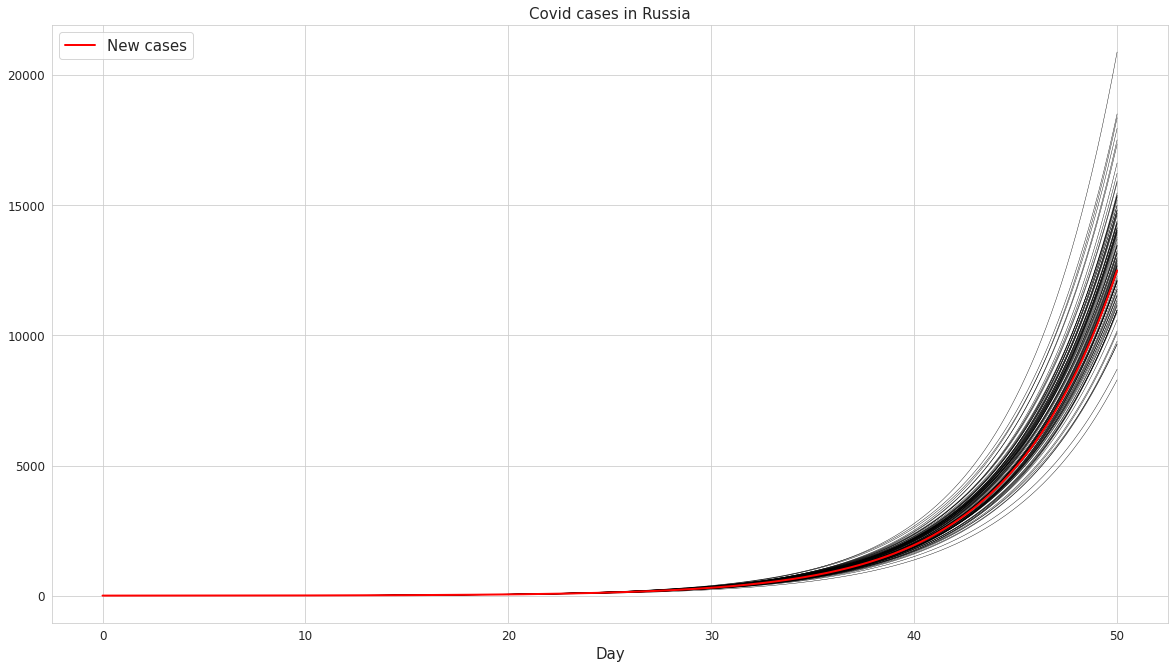

In [64]:
plot_exponents(n=100, mu=mu_new, sigma=sigma_new, cases='new')

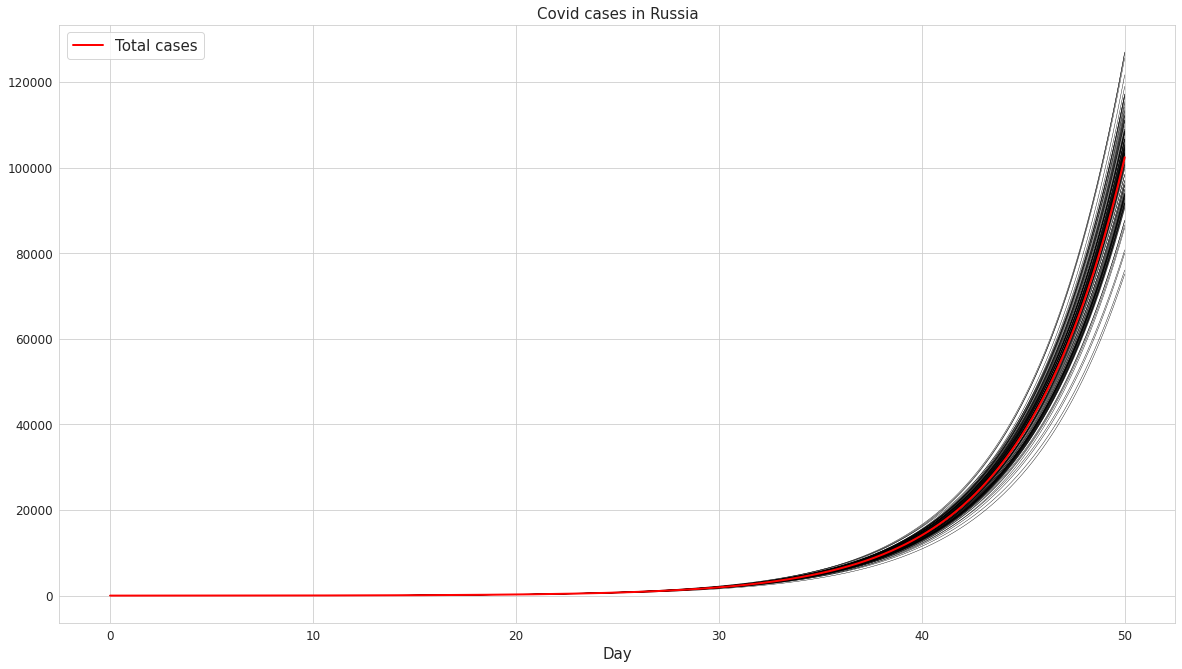

In [65]:
plot_exponents(n=100, mu=mu_total, sigma=sigma_total, cases="total")

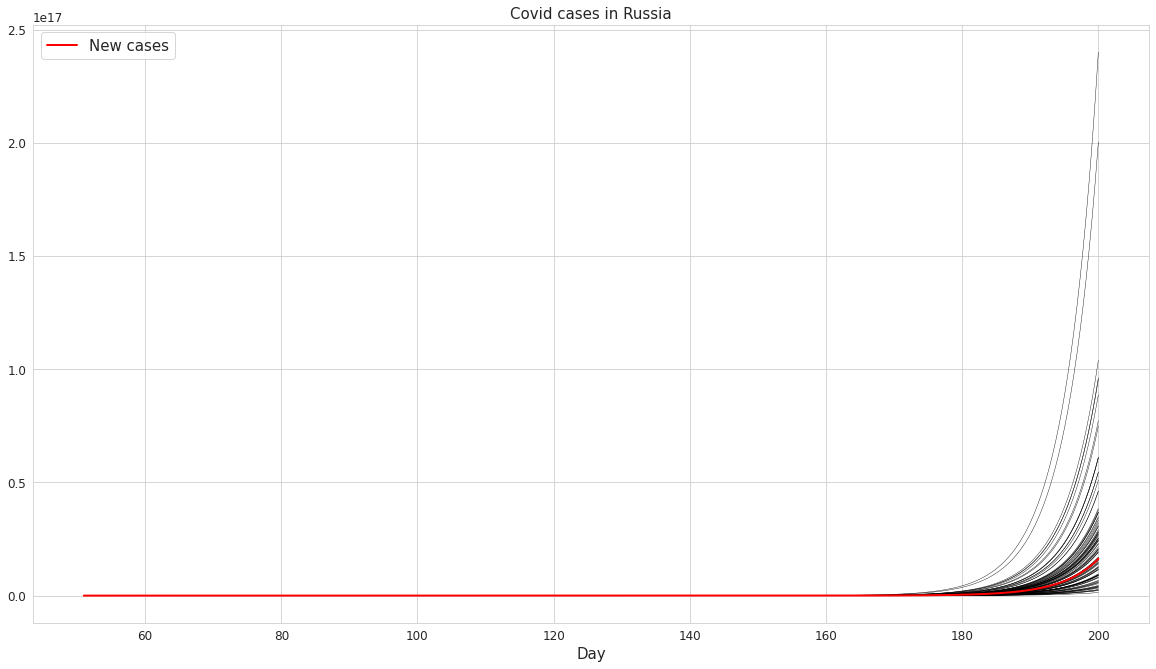

In [66]:
x_test = np.linspace(51, 200, N)
plot_exponents(n=100, mu=mu_new, sigma=sigma_new, cases='new', mode="test")

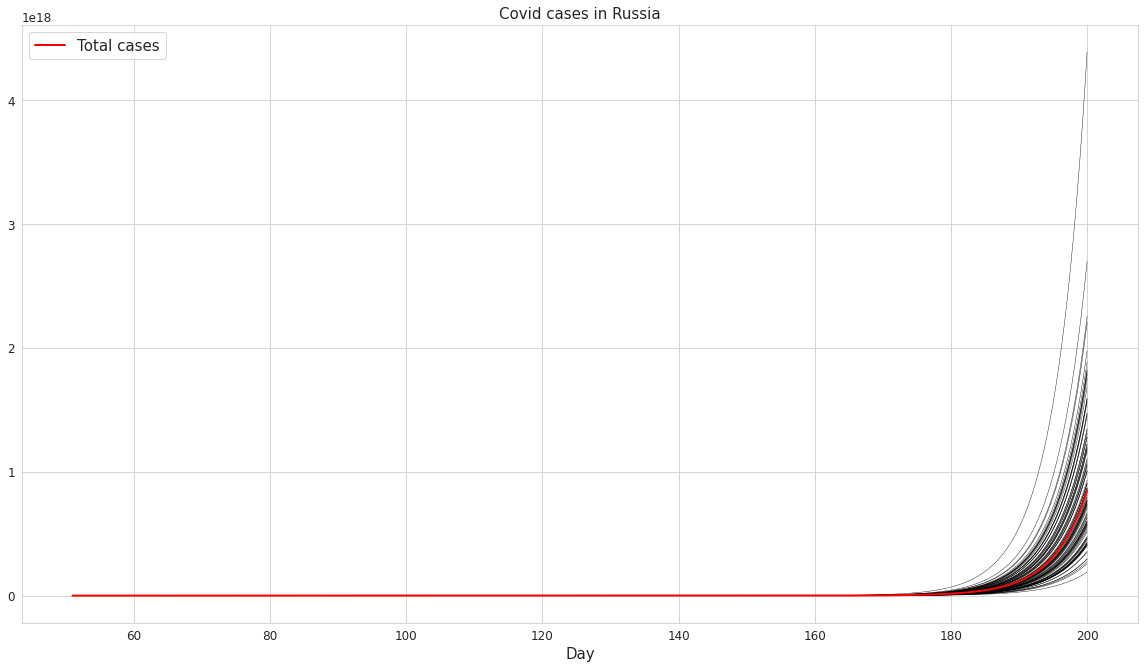

In [67]:
plot_exponents(n=100, mu=mu_total, sigma=sigma_total, cases="total", mode="test")

In [68]:
total_cases_w = np.random.multivariate_normal(mu_total, sigma_total, 100)
may_total = np.mean(list(map(lambda w: np.exp(w[1] * before_may_days + w[0]), total_cases_w)))
jun_total = np.mean(list(map(lambda w: np.exp(w[1] * before_jun_days + w[0]), total_cases_w)))
sep_total = np.mean(list(map(lambda w: np.exp(w[1] * before_sep_days + w[0]), total_cases_w)))
print("Number of cases by May 1: {}\nNumber of cases by June 1: {}\nNumber of cases by September 1: {}"
.format(may_total, jun_total, sep_total))

Number of cases by May 1: 608323.1309378758
Number of cases by June 1: 286437172.58963454
Number of cases by September 1: 2.5989069446686076e+16


# 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана.
$$ \Phi (x) = \frac{1}{\sqrt{2\pi}} \int_{-∞}^{x} e^{-\frac{t^2}{2}} dt$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от $t$.

## a
Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Продифференциируем функцию, получим экспоненту с константой, чтобы избавиться от экспоненты возьмем логарифм. Очевидно, что производная общего количества заолевших - количество новых заболевших.

## b
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [69]:
train_df.loc[:, "index_square"] = train_df["index"].apply(lambda x: x ** 2)
test_df.loc[:, "index_square"] = test_df["index"].apply(lambda x: x ** 2)

lr_new_sigmoid = LinearRegression().fit(train_df.loc[:, ["index", "index_square"]], np.log(train_df["new_cases"]))
std = np.std(np.log(train_df["new_cases"]) - lr_new_sigmoid.predict(train_df.loc[:, ["index", "index_square"]]))
mu_new_sigmoid = np.array([lr_new_sigmoid.intercept_, lr_new_sigmoid.coef_[0], lr_new_sigmoid.coef_[1]], dtype="float32")
    
cur_mu_new_sigmoid, cur_sigma_new_sigmoid = mu_new_sigmoid, np.eye(3, dtype="float32")
for index, row in train_df.iterrows():
    cur_mu_new_sigmoid, cur_sigma_new_sigmoid = bayesian_update(mu_0=cur_mu_new_sigmoid, sigma_0=cur_sigma_new_sigmoid, 
                                                                x=row[["index", "index_square"]].values, y=np.log(row["new_cases"]),
                                                                std=std)

## c
Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


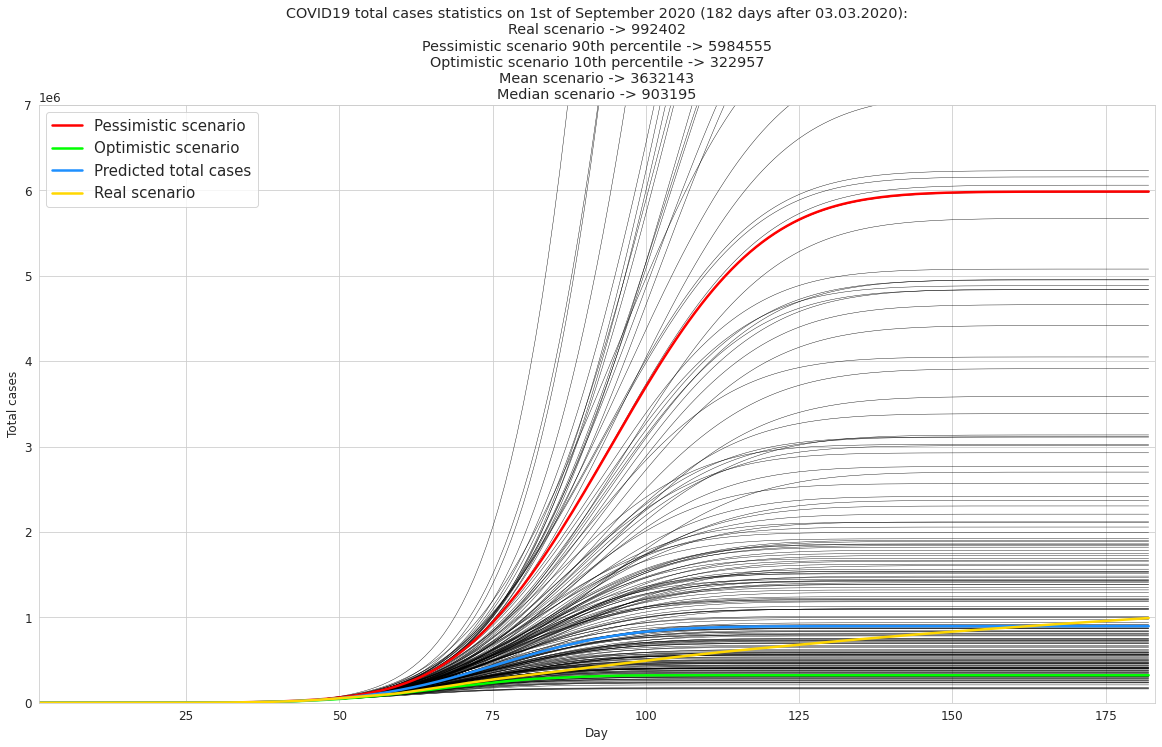

In [71]:
x_range = np.arange(1, 183)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
weights = np.random.multivariate_normal(cur_mu_new_sigmoid, cur_sigma_new_sigmoid, 200)
total_cases_samples = np.empty([1, len(x_range)])
for w in weights:
    sample = np.cumsum(np.exp(w[0] + w[1] * x_range + w[2] * x_range * x_range))
    total_cases_samples = np.vstack((total_cases_samples, sample))
    ax.plot(x_range, sample, 'k-', lw=.4)
total_cases_samples = total_cases_samples[1:,:]
ax.plot(x_range, np.quantile(total_cases_samples, q=0.9, axis=0), 'k-', lw=2.5, c="red", label="Pessimistic scenario")
ax.plot(x_range, np.quantile(total_cases_samples, q=0.1, axis=0), 'k-', lw=2.5, c="lime", label="Optimistic scenario")
ax.plot(x_range, np.cumsum(np.exp(lr_new_sigmoid.predict(np.hstack((x_range.reshape(-1, 1), x_range.reshape(-1, 1) ** 2))))), 'k-', lw=2.5, c="dodgerblue", label="Predicted total cases")
ax.plot(x_range, covid_df.loc[covid_df["index"] <= 182]["total_cases"], 'k-', lw=2.5, c="gold", label="Real scenario")
ax.set_xlim((1, 183))
ax.set_ylim((0, 7e6))
ax.set_xlabel("Day")
ax.set_ylabel("Total cases")
pess_sc245 = np.quantile(total_cases_samples[:,(before_sep_days - 1)], q=0.9)
opt_sc245 = np.quantile(total_cases_samples[:,(before_sep_days - 1)], q=0.1)
mean_sc245 = np.mean(total_cases_samples[:,(before_sep_days - 1)])
med_sc245 = np.quantile(total_cases_samples[:,(before_sep_days - 1)], q=0.5)
real_cases = f"Real scenario -> {int(covid_df.loc[covid_df['index'] == before_sep_days]['total_cases'].values[0])}"
predicted_pess = f"Pessimistic scenario 90th percentile -> {int(pess_sc245)}"
predicted_opt = f"Optimistic scenario 10th percentile -> {int(opt_sc245)}"
predicted_mean = f"Mean scenario -> {int(mean_sc245)}"
predicted_med = f"Median scenario -> {int(med_sc245)}"
tmp_title = "COVID19 total cases statistics on 1st of September 2020 (182 days after 03.03.2020):"

ax.set_title("\n".join([tmp_title, real_cases, predicted_pess, predicted_opt, predicted_mean, predicted_med]))
ax.legend(fontsize=legend_fontsize)
plt.show()

# 5
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?

Неплохой выбор для моделирования коронавируса или любых других процессов с быстрым ростом и стадией насыщения - сигмоидные функции. В реальной жизни все гораздо сложнее, но использовать такие прогнозы можно для нижних и верхних границ на ранних этапах.